# News

https://open-data-battle.geecko.com/issues/news

 Мы решили торговать на бирже, причем так, чтобы решение о покупке акций принимала нейросеть на основе последних новостей о той или иной компании. Для этого нужно научиться классифицировать все новости. Дана база новостей из разных источников news.csv. Необходимо написать классифицирующую модель новостей по источникам.

Напиши любую модель для предсказания источника новостей и предскажите источники для данных из файла news.csv, для которых отсутствует значение Source.

Пороговые значения для данной задачи классификации считать равными 0.33, 0.66.

Ответ необходимо прикрепить в файле формата CSV. Файл должен содержать только прогнозные значения Source в одном столбце без заголовка. 

[Пример анализа](https://www.machinelearningmastery.ru/text-classification-in-python-dd95d264c802/)

[Еще пример](https://nuancesprog.ru/p/12991/)

In [1]:
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
# print('Extracting ZIP.')
# with zipfile.ZipFile('news.zip', 'r') as archive:# Extract to current directory
#     archive.extractall('.')
# print('ZIP Extracted.')

# 1. Разведочный анализ

In [3]:
df = pd.read_csv('Data/news (1).csv', index_col=0)
df.head()

,news,source
0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,Практически во всех странах мира введены огра...,0.0
3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,Совет директоров «Почты России» проголосовал ...,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19462 entries, 0 to 19461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   news    19462 non-null  object 
 1   source  18360 non-null  float64
dtypes: float64(1), object(1)
memory usage: 456.1+ KB


В колонке news пропусков нет, в колонке source есть пропуски - это то что надо предсказать

In [5]:
df.source.unique()

array([ 1.,  0.,  2., nan])

Всего 3 уникальных источника

Создадим колонку с количеством символов текста

In [6]:
df['lenght'] = df['news'].apply(str.strip).apply(len)
df.head()

,news,source,lenght
0,Официальный аккаунт PlayStation опубликовал т...,1.0,593
1,Китайская компания Mobvoi опубликовала на офи...,1.0,772
2,Практически во всех странах мира введены огра...,0.0,2833
3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0,3993
4,Совет директоров «Почты России» проголосовал ...,2.0,597


Разделим данные на тренировочные и те что нужно предсказать

In [7]:
df_predict = df[df['source'].isna()]
df_train = df[~df['source'].isna()]

Посмотрим как распределятся данные по длине и источника. При этом ограничимся длиной 10000

<AxesSubplot:xlabel='source', ylabel='lenght'>

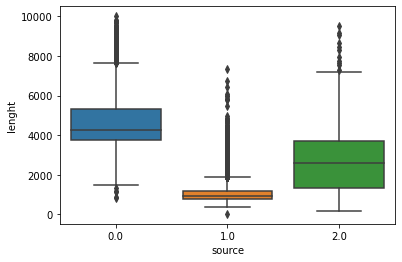

In [8]:
df_plot = df_train[df_train['lenght'] <=10000]
sns.boxplot(x="source", y="lenght", data=df_plot)

# *pyLDAvis

In [9]:
# !pip install pyldavis

In [10]:
# import pyLDAvis
# import pyLDAvis.sklearn
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

In [11]:
# pyLDAvis.enable_notebook()

# text = df_train[['news']].to_numpy()
# text = np.squeeze(text)

# tf_vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                 max_df = 0.5, 
#                                 min_df = 10)
# tf_vectorizer.fit(text)

# dtm_tf = tf_vectorizer.transform(text)

# lda_tf = LatentDirichletAllocation(n_components=20)
# lda_tf.fit(dtm_tf)

# pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

# 2. Базовая модель. Мешок слов

## 2.1 Подготовка текста

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

Преобразуем серии в эрэи

In [13]:
news = df_train['news'].values
source = df_train['source'].values

In [14]:
news_pred = df_predict['news'].values

Разделим данные на тренировочные и тестовые

In [15]:
news_train, news_test, y_train, y_test = train_test_split(
   news, source, test_size=0.25, random_state=1000)

Токенезация и векторизация текста

`CountVectorizer` создает словарь, в котором ключ - слово, значение - порядковый номер.

Исходный текст векторизуется, номер слова в словаре = номеру элемента вектора, где вместо слов - количество вхождения слова в текст. 

In [16]:
vectorizer = CountVectorizer(token_pattern=r'\b\w\w\w+\b',  # токен - минимум 3 символа
                            max_df=0.7, # максимальное число слова - пропорциоанльное всему словарю
                            min_df=5)   # минимальное число повторов токена (слова)

X_train = vectorizer.fit_transform(news_train)
X_test = vectorizer.transform(news_test)

# TODO TfidfVectorizer

[](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

# TODO NLTK

[NLTK](https://www.nltk.org/api/nltk.tokenize.html)

## 2.2 Обучение модели

Метод опорных векторов

In [17]:
clf = LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9821350762527233

Логистическая регрессия

In [18]:
clf2 = LogisticRegression(max_iter=1000)
clf2.fit(X_train, y_train)
clf2.score(X_test, y_test)

0.9812636165577342

# TODO к-ближайших соседей, рэндом форест

## 2.3 Предсказание модели

In [19]:
news_pred = df_predict['news'].values
X_pred = vectorizer.transform(news_pred)

In [20]:
np.savetxt('news_res_logreg.csv', clf2.predict(X_pred), fmt='%d')

Прошел проверку)

# 3. Нейронные сети

[Классификация текста - ютуб](https://www.youtube.com/watch?v=cPkH1k3U1c8&list=LL&index=10&t=937s)

[Пример нейросетей](https://cyberguru.tech/%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5/%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5/%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F-%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0-%D1%81)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

## 3.1 Токенизация, векторизация текста

In [22]:
# Максимальное количество слов в словаре
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 3

[Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer?hl=ru)

Создаем токенизатор, обучаем его на новостях и просматриваем словарь токенизатора

In [23]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n—–1234567890«»→',
                     num_words=num_words)

tokenizer.fit_on_texts(news_train)
tokenizer.word_index

{'в': 1,
 'и': 2,
 'на': 3,
 'с': 4,
 'что': 5,
 'не': 6,
 'по': 7,
 'для': 8,
 'из': 9,
 'а': 10,
 'к': 11,
 'за': 12,
 'о': 13,
 'как': 14,
 'от': 15,
 'это': 16,
 'но': 17,
 'также': 18,
 'компании': 19,
 'года': 20,
 'он': 21,
 'до': 22,
 'будет': 23,
 'его': 24,
 'у': 25,
 'apple': 26,
 'при': 27,
 'рублей': 28,
 'или': 29,
 'то': 30,
 'компания': 31,
 'так': 32,
 'которые': 33,
 'г': 34,
 'google': 35,
 'все': 36,
 'уже': 37,
 'этом': 38,
 'россии': 39,
 'можно': 40,
 'того': 41,
 'их': 42,
 'может': 43,
 'том': 44,
 'более': 45,
 'только': 46,
 'году': 47,
 'мы': 48,
 'если': 49,
 'который': 50,
 'гб': 51,
 'чтобы': 52,
 'млн': 53,
 'же': 54,
 'iphone': 55,
 'после': 56,
 'пользователей': 57,
 'есть': 58,
 'время': 59,
 'они': 60,
 'со': 61,
 'сша': 62,
 'во': 63,
 'млрд': 64,
 'этого': 65,
 'android': 66,
 'интернет': 67,
 'будут': 68,
 'pro': 69,
 'об': 70,
 'кроме': 71,
 'еще': 72,
 'могут': 73,
 'facebook': 74,
 'был': 75,
 'под': 76,
 'было': 77,
 'сети': 78,
 'руб': 79,
 '

Всего новостей

In [24]:
tokenizer.document_count

13770

Выделяем правильные ответы

In [25]:
y_train

array([0., 1., 1., ..., 1., 1., 0.])

In [26]:
utils.to_categorical(y_train, 3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [27]:
y_train = utils.to_categorical(y_train, 3)
y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [28]:
y_test = utils.to_categorical(y_test, 3)
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [29]:
y_train.shape

(13770, 3)

Преобразуем новости в числовое представление

In [30]:
sequences = tokenizer.texts_to_sequences(news_train)

In [31]:
sequences_test = tokenizer.texts_to_sequences(news_test)

In [32]:
sequences_pred = tokenizer.texts_to_sequences(news_pred)

In [33]:
index = 1
print(news_train[index], sequences[index], sep='\n\n')

 Социальная сеть Facebook призналась в передаче сторонним приложениям персональных данных пользователей Facebook и Instagram, которые не заходили в соцсети более 90 дней. Уточняется, что несколько тысяч приложений получили доступ к данным пользователей. В 2018 году Facebook ввела новые правила — приложения, в которых пользователь авторизовался через Facebook или Instagram, не должны получать информацию об аккаунте, если его перестали использовать в течение 90 дней. В Facebook обнаружили, что некоторые приложения продолжали собирать информацию о пользователях, даже если те не заходили в аккаунт более 90 дней. Как долго продолжалась передача данных и какое количество пользователей затронула эта проблема, в компании не уточнили. Также в Facebook не назвали, какие конкретно данные передавались на сторону, но отметили, что пользователи ранее сами разрешили приложениям доступ к этой информации. По словам представителей социальной сети, на данный момент проблема устранена. 

[1193, 258, 74, 1

In [34]:
tokenizer.word_index['сеть']

258

Ограничиваем длину отзывов

In [35]:
x_train = pad_sequences(sequences, maxlen=max_news_len)
x_train.shape

(13770, 30)

In [36]:
x_test = pad_sequences(sequences_test, maxlen=max_news_len)

In [37]:
x_pred = pad_sequences(sequences_pred, maxlen=max_news_len)

In [38]:
x_train[1]

array([  18,    1,   74,    6, 2693,  658, 7575,  116,    3, 1854,   17,
       1074,    5,  134,   88,  886, 4434,  159,   11,  146,  124,    7,
         92, 1678,  394,   78,    3,  656,  183,  714])

## 3.2 Обучение моделей

## Полносвязная сеть (самая обычная)

In [39]:
model = Sequential()
model.add(Dense(10, input_dim=max_news_len, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [40]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_train, 
                            y_train, 
                            epochs=15,
                            batch_size=30,
                            validation_split=0.1
                            )

Epoch 1/15
414/414 [==============================] - 2s 4ms/step - loss: 373.0970 - accuracy: 0.4951 - val_loss: 70.0626 - val_accuracy: 0.5940
Epoch 2/15
414/414 [==============================] - 1s 2ms/step - loss: 27.1807 - accuracy: 0.6153 - val_loss: 16.0730 - val_accuracy: 0.6122
Epoch 3/15
414/414 [==============================] - 1s 2ms/step - loss: 6.7637 - accuracy: 0.6301 - val_loss: 8.1660 - val_accuracy: 0.6137
Epoch 4/15
414/414 [==============================] - 1s 2ms/step - loss: 3.0736 - accuracy: 0.6321 - val_loss: 5.4462 - val_accuracy: 0.6173
Epoch 5/15
414/414 [==============================] - 1s 2ms/step - loss: 1.8395 - accuracy: 0.6339 - val_loss: 3.9684 - val_accuracy: 0.6173
Epoch 6/15
414/414 [==============================] - 1s 2ms/step - loss: 1.3437 - accuracy: 0.6347 - val_loss: 3.2832 - val_accuracy: 0.6144
Epoch 7/15
414/414 [==============================] - 1s 2ms/step - loss: 1.1388 - accuracy: 0.6344 - val_loss: 2.8352 - val_accuracy: 0.6180
E

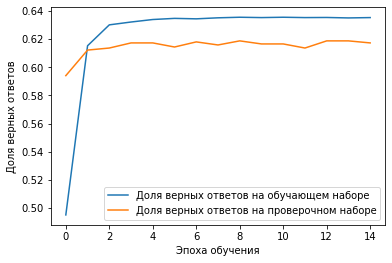

In [43]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Embedding (Вложения слов)

https://www.tensorflow.org/text/guide/word_embeddings?hl=ru

In [44]:
embedding_dim = 50

model_emb = Sequential()
model_emb.add(Embedding(input_dim=num_words, 
                           output_dim=embedding_dim, 
                           input_length=max_news_len))
model_emb.add(Flatten())
model_emb.add(Dense(10, activation='relu'))
model_emb.add(Dense(3, activation='softmax'))
model_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_emb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            500000    
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                15010     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 515,043
Trainable params: 515,043
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_emb = model_emb.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=10,
                            validation_split=0.1
                            )

Epoch 1/5
1240/1240 [==============================] - 17s 14ms/step - loss: 0.2988 - accuracy: 0.7919 - val_loss: 0.2177 - val_accuracy: 0.8584
Epoch 2/5
1240/1240 [==============================] - 17s 13ms/step - loss: 0.0697 - accuracy: 0.9635 - val_loss: 0.2427 - val_accuracy: 0.8548
Epoch 3/5
1240/1240 [==============================] - 17s 14ms/step - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.2854 - val_accuracy: 0.8519
Epoch 4/5
1240/1240 [==============================] - 17s 14ms/step - loss: 7.9328e-04 - accuracy: 0.9999 - val_loss: 0.3169 - val_accuracy: 0.8627
Epoch 5/5
1240/1240 [==============================] - 18s 14ms/step - loss: 2.4768e-04 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.8627


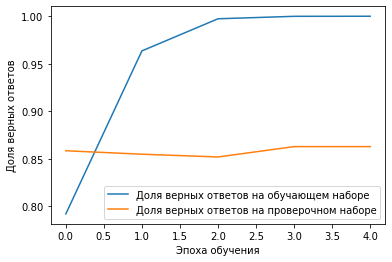

In [46]:
plt.plot(history_emb.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_emb.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Оценка точности модели на тестовых данных

In [47]:
model_emb.evaluate(x_test, y_test, verbose=1)

144/144 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8745


[0.2949009835720062, 0.8745098114013672]

Предсказание

In [48]:
model_emb_res = model_emb.predict(x_pred).argmax(axis=1)
model_emb_res

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [49]:
np.savetxt('news_res_model_emb.csv', model_emb_res, fmt='%d')

## Сверточная НС

In [50]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(3, activation='softmax'))

In [51]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [52]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 250)           40250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 392,765
Trainable params: 392,765
Non-trainable params: 0
_________________________________________________________________


In [53]:
# model_cnn_save_path = 'best_model_cnn.h5'
# checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
#                                       monitor='val_accuracy',
#                                       save_best_only=True,
#                                       verbose=1)

In [54]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=10,
                            validation_split=0.1
                            )

Epoch 1/5
1240/1240 [==============================] - 17s 14ms/step - loss: 0.5172 - accuracy: 0.7769 - val_loss: 0.4103 - val_accuracy: 0.8359
Epoch 2/5
1240/1240 [==============================] - 15s 12ms/step - loss: 0.2063 - accuracy: 0.9258 - val_loss: 0.4211 - val_accuracy: 0.8526
Epoch 3/5
1240/1240 [==============================] - 15s 12ms/step - loss: 0.0467 - accuracy: 0.9850 - val_loss: 0.6407 - val_accuracy: 0.8424
Epoch 4/5
1240/1240 [==============================] - 15s 12ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.9390 - val_accuracy: 0.8344
Epoch 5/5
1240/1240 [==============================] - 15s 12ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.9868 - val_accuracy: 0.8410


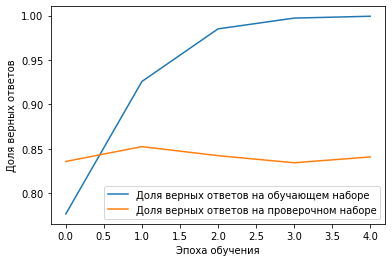

In [55]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

[Ошибка в сопоставивости numpy и tensorflov](https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t)

In [56]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(3, activation='softmax'))

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [57]:
num_words

10000

In [58]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Cеть GRU

In [59]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(4, activation='softmax'))

NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported